In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

### Preparing the dataset

In [2]:
words = open("names.txt", "r").read().splitlines()

In [3]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(stoi)
vocab_size

27

In [4]:
block_size = 3
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    
    for w in words:
    
        context = [0] * block_size
        for ch in w+".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
    
            context = context[1:]+[ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)   

    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

### Defining the layers

In [5]:
from makemore.linear import Linear
from makemore.tanh import Tanh
from makemore.batchNorm1d import BatchNorm1d

In [6]:
n_embed = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)


layers = [
  Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


### Training loop

In [11]:
%%time

max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    x = emb.view(-1, block_size * n_embed)

    for layer in layers:
        x = layer(x)
    
    loss = F.cross_entropy(x, Yb)

     # backward pass
    for layer in layers:
      layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
      
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    with torch.no_grad(): #checks how large are the update compared to values
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    # # if i >= 1000:
    # #   break # AFTER_DEBUG: would take out obviously to run full optimization
    # if i % 10000 == 0: # print every once in a while
    #   print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    # lossi.append(loss.log10().item())

      0/ 200000: 2.1189
  10000/ 200000: 2.4210
  20000/ 200000: 1.8325
  30000/ 200000: 1.9717
  40000/ 200000: 1.9369
  50000/ 200000: 2.8048
  60000/ 200000: 1.9833
  70000/ 200000: 2.0637
  80000/ 200000: 2.3088
  90000/ 200000: 2.2504
 100000/ 200000: 2.0926
 110000/ 200000: 2.0370
 120000/ 200000: 1.8982
 130000/ 200000: 1.5689
 140000/ 200000: 2.0867
 150000/ 200000: 1.9026
 160000/ 200000: 1.6841
 170000/ 200000: 1.5990
 180000/ 200000: 1.8545
 190000/ 200000: 2.1288
CPU times: user 55min 2s, sys: 13.5 s, total: 55min 15s
Wall time: 9min 54s


### Evaluation

In [12]:
for layer in layers:
    layer.training = False

In [13]:
@torch.no_grad()
def split_loss(split):
    x, y = {
       "train" : (Xtr, Ytr),
        "test" : (Xte, Yte),
        "dev": (Xdev, Ydev)
    }[split] 
    emb = C[x]
    x = emb.view(emb.shape[0], -1)

    for layer in layers:
        x = layer(x)    
    
    loss = F.cross_entropy(x, y)
    print(split, loss.item()) 

split_loss("train")
split_loss("dev")

train 1.96268630027771
dev 2.09045672416687


### Sample from the data

In [17]:
for _ in range(20):
    context = [0]*block_size
    out = []

    while True:
        emb = C[torch.tensor([context])]

        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)

        logits = x
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1).item()

        context = context[1:] + [ix]
        out.append(ix)

        if ix==0:
            break

    print("".join(itos[i] for i in out))
    
    

mayan.
abdulkota.
kameel.
phoailah.
zelarshika.
aah.
vika.
dashi.
maxzeyan.
jeya.
kah.
ozemani.
hapmaddie.
kaegen.
shannathl.
calunay.
zaidalyn.
sim.
westyn.
araahi.


### Visualizing loss

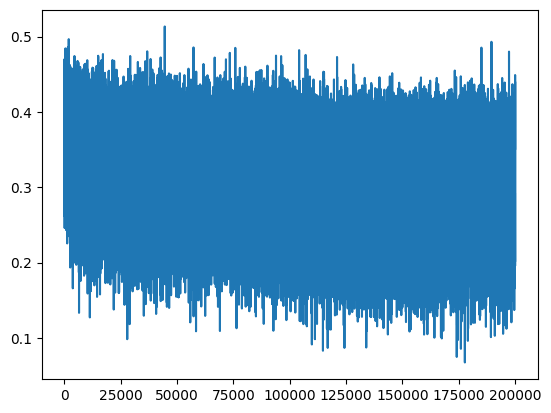

In [18]:
plt.plot(lossi)

In [20]:
len(lossi)

200000

this looks too ugly

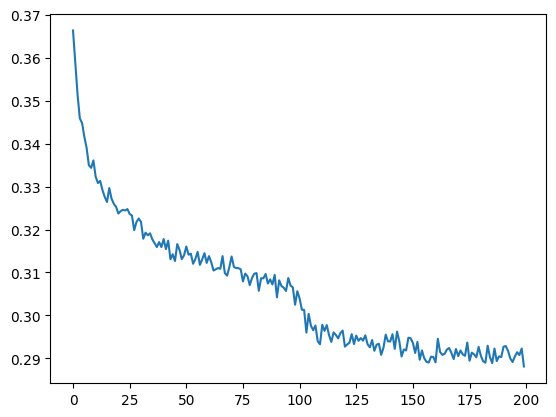

In [21]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

the steep fall at around 100 is due to the learning rate decay

### Cleaning up layers

In [5]:
from makemore.linear import Linear
from makemore.tanh import Tanh
from makemore.batchNorm1d import BatchNorm1d

from makemore.embedding import Embedding
from makemore.flatten import Flatten

In [6]:
from makemore.sequential import Sequential

In [7]:
n_embed = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

# C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    
  Embedding(vocab_size, n_embed),
  Flatten(),
  Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]


model = Sequential([
  Embedding(vocab_size, n_embed),
  Flatten(),
  Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
])

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [8]:
%%time

max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # emb = C[Xb]
    # x = emb.view(-1, block_size * n_embed)
    
    # x = Xb
    # for layer in layers:
    #     x = layer(x)

    logits = model(Xb)
    
    # loss = F.cross_entropy(x, Yb)
    loss = F.cross_entropy(logits, Yb)

     # backward pass
    # for layer in layers:
    #   layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
      
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    with torch.no_grad(): #checks how large are the update compared to values
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    # if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization
    # if i % 10000 == 0: # print every once in a while
    #   print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    # lossi.append(loss.log10().item())

      0/ 200000: 3.7937
CPU times: user 268 ms, sys: 26.8 ms, total: 295 ms
Wall time: 99.6 ms


### Evaluation

In [10]:
@torch.no_grad()
def split_loss(split):
    x, y = {
       "train" : (Xtr, Ytr),
        "test" : (Xte, Yte),
        "dev": (Xdev, Ydev)
    }[split] 
    # emb = C[x]
    # x = emb.view(emb.shape[0], -1)

    # for layer in layers:
    #     x = layer(x)    

    logits = model(x)
    
    loss = F.cross_entropy(logits, y)
    print(split, loss.item()) 

split_loss("train")
split_loss("dev")

train 3.3055880069732666
dev 3.302670478820801


### Sample from data

In [11]:
for _ in range(20):
    context = [0]*block_size
    out = []

    while True:
        # emb = C[torch.tensor([context])]

        # x = emb.view(emb.shape[0], -1)
        # for layer in layers:
        #     x = layer(x)

        # logits = x

        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1).item()

        context = context[1:] + [ix]
        out.append(ix)

        if ix==0:
            break

    print("".join(itos[i] for i in out))
    
    

caqzouiuffq.
lmscscyhzqcpxlnmmxwjyeysxapspbliexabm.
yyyswkcqdelapqtqbjytignqeqzaofhtcohbeaphztrlduvayhybwczhyqztbtwkygnfohhhqbcrzoewbrmyleq.
buwwqltmyzvbrfthctpyhtmournraahb.
srrrfhilsupniamwlabbievwjwd.
vktajz.
ysqpvfovsmmyhhgc.
qpjchoysgfjhugsjdh.
orvdkos.
eqpjhorsupyte.
nflyomq.
fazhd.
.
qywlnptwdbenhz.
fvdjrcfw.
haxhdmkalcyqbxiyiveybxpjqdmvniktkyzdmupgkl.
ih.
oekoylxobjqnoj.
s.
.


the error is because layers arent in training mode.so batchnorm being activated and variance of a single number isnt a number

the layers are in eval mode

In [9]:
for layer in model.layers:
    layer.training = False

In [12]:
for _ in range(20):
    context = [0]*block_size
    out = []

    while True:
        # emb = C[torch.tensor([context])]

        # x = emb.view(emb.shape[0], -1)
        # for layer in layers:
        #     x = layer(x)

        # logits = x

        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1).item()

        context = context[1:] + [ix]
        out.append(ix)

        if ix==0:
            break

    print("".join(itos[i] for i in out))

lfjdyqdauekgktgvkiwoyhmjzx.
.
mv.
lkqzaalgyllrpnhohlqswbuciik.
clfommtnzfxuelxbe.
.
sszcre.
ejtkbkvwudtmmtjsgroklahcledhdcmicbcxmpbm.
vtvbhduvejtzhhysskyzp.
adazb.
.
cdtrxn.
bqxkuswdeosorymjawzeuqnhyiria.
fqqvotpbblygxbt.
cqscelunkhs.
dmbwlokelenfyzwjra.
.
deacjihfziwefqtaqh.
dajip.
pk.


### Change Dataset Context Length

In [8]:
block_size = 8
def build_dataset(words):
    X, Y = [], []
    
    for w in words:
    
        context = [0] * block_size
        for ch in w+".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
    
            context = context[1:]+[ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)   

    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [9]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

........ ---> e
.......e ---> b
......eb ---> r
.....ebr ---> i
....ebri ---> m
...ebrim ---> a
..ebrima ---> .
........ ---> h
.......h ---> i
......hi ---> l
.....hil ---> t
....hilt ---> o
...hilto ---> n
..hilton ---> .
........ ---> j
.......j ---> h
......jh ---> e
.....jhe ---> n
....jhen ---> e
...jhene ---> .


In [10]:
n_embed = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

# C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    
  Embedding(vocab_size, n_embed),
  Flatten(),
  Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]


model = Sequential([
  Embedding(vocab_size, n_embed),
  Flatten(),
  Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
])

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

52024


Number of parameters has increased but still not much effective. because crushing too much information at the first layer

#### Training

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
Xtr, Ytr = Xtr.to(device), Ytr.to(device)
for p in parameters:
    p = p.to(device)

In [15]:
%%time

max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    ix = ix.to(device)
    Xb, Yb = Xtr[ix], Ytr[ix]

    Xb = Xb.to(device)
    Yb = Yb.to(device)
    # emb = C[Xb]
    # x = emb.view(-1, block_size * n_embed)
    
    # x = Xb
    # for layer in layers:
    #     x = layer(x)

    logits = model(Xb)
    
    # loss = F.cross_entropy(x, Yb)
    loss = F.cross_entropy(logits, Yb)

     # backward pass
    # for layer in layers:
    #   layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
      
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    with torch.no_grad(): #checks how large are the update compared to values
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    # if i >= 1000:
    # break # AFTER_DEBUG: would take out obviously to run full optimization
    # if i % 10000 == 0: # print every once in a while
    #   print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    # lossi.append(loss.log10().item())

      0/ 200000: 3.5122
  10000/ 200000: 2.3321
  20000/ 200000: 1.8866
  30000/ 200000: 1.8489
  40000/ 200000: 2.2040
  50000/ 200000: 2.1646
  60000/ 200000: 1.8606
  70000/ 200000: 1.9460
  80000/ 200000: 2.0502
  90000/ 200000: 2.1754
 100000/ 200000: 1.6681
 110000/ 200000: 2.2135
 120000/ 200000: 1.8240
 130000/ 200000: 2.2933
 140000/ 200000: 2.1262
 150000/ 200000: 1.9064
 160000/ 200000: 1.6681
 170000/ 200000: 2.1288
 180000/ 200000: 2.1957
 190000/ 200000: 2.0349
CPU times: user 1h 1min 49s, sys: 9.68 s, total: 1h 1min 58s
Wall time: 10min 39s


In [16]:
for layer in model.layers:
    layer.training = False

In [17]:
@torch.no_grad()
def split_loss(split):
    x, y = {
       "train" : (Xtr, Ytr),
        "test" : (Xte, Yte),
        "dev": (Xdev, Ydev)
    }[split] 

    logits = model(x)
    
    loss = F.cross_entropy(logits, y)
    print(split, loss.item()) 

split_loss("train")
split_loss("dev")

train 1.8525460958480835
dev 1.999637484550476


Increasing context length has reduced the loss but still a lot of information being squashed at the first layer

#### Logging

Context len: 3 loss: 2.10
Context len: 8 loss: 1.99

#### Scratch space

In [19]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0, 26,  1,  6,  9],
        [ 0,  0,  0,  0,  0,  0,  0,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0, 16, 18]])

In [20]:
model.layers[0].out.shape #embedding layer

torch.Size([4, 8, 10])

In [21]:
model.layers[1].out.shape #flatten layer

torch.Size([4, 80])

In [23]:

model.layers[2].out.shape #linear layer

torch.Size([4, 100])

In [24]:
(torch.randn(4, 80) @ torch.randn(80,100) + torch.randn(100)).shape

torch.Size([4, 100])

In [25]:

(torch.randn(4,5, 80) @ torch.randn(80,100) + torch.randn(100)).shape

torch.Size([4, 5, 100])

any batch dimension can be added before the last dimension

we want to create 4 extra batch dimension corresponding to 4 bigram groups

Two consecutive characters packed into one group at the last dimenstion
(1, 2), (3, 4), (5, 6), (7, 8). We need to change the flatten layer

In [31]:
e = torch.randn(4, 8, 10) # want this to be (4, 2, 20) where consecutive 10D vectors get concatenated
e.shape

torch.Size([4, 8, 10])

In [26]:
#even parts 
print(list(range(10))[::2])
#odd parts
print(list(range(10))[1::2])

[0, 2, 4, 6, 8]
[1, 3, 5, 7, 9]


In [29]:
#even parts
e[:,::2,:].shape

torch.Size([4, 4, 10])

In [30]:
#odd parts
e[:,1::2,:].shape

torch.Size([4, 4, 10])

In [32]:
torch.cat((e[:,::2,:], e[:,1::2,:]), dim=2).shape

torch.Size([4, 4, 20])

we can concatenate the even and odd parts to obtain consecutive characters

In [37]:
(e.view(4,4,20)==torch.cat((e[:,::2,:], e[:,1::2,:]), dim=2)).all()

tensor(True)